In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

MAX_DEPTH = 20
PROB_BRANCH = 0.4
VALUES = range(1, 10)
OPS_E = [0, 1]
OPS_T = [2, 3]
NTYPES = ['e', 't']
OP_MAP = ['+', '-', '*', '/']

In [2]:
def gen_expr(depth, ntype):

    if depth < MAX_DEPTH:
        r = random.random()
    else:
        r = 1

    if r > PROB_BRANCH:
        if ntype == 'f':
            value = random.choice(VALUES)
            return value
        elif ntype == 't':
            return gen_expr(depth + 1, 'f')
        elif ntype == 'e':
            return gen_expr(depth + 1, 't')

    else:
        if ntype == 'e':
            op = random.choice(OPS_E)
            v1, v2 = gen_expr(depth + 2, 'e'), gen_expr(depth + 1, 't')
            t = ((v1, OP_MAP[op]), v2)
        elif ntype == 't':
            op = random.choice(OPS_T)
            v1, v2 = gen_expr(depth + 2, 't'), gen_expr(depth + 1, 'f')
            t = ((v1, OP_MAP[op]), v2)
        else:
            t = gen_expr(depth + 1, 'f')

    return t

In [3]:
def gen_tree():
    return gen_expr(0, 'e')

In [4]:
def to_value(t):
    if not isinstance(t, tuple):
        return t

    l = t[0]
    r = t[1]
    v1, op = (to_value(l[0]), l[1])
    v2 = to_value(r)

    return eval(''.join([str(v1), op, str(v2)]))

In [5]:
def to_value_sd(sd_lst, node_lst):
    if len(sd_lst) == 0:
        node = node_lst[0]
        v = node
    else:
        i = np.argmax(sd_lst)
        child_l, v_l = to_value_sd(sd_lst[:i], node_lst[:i+1])
        child_r, v_r = to_value_sd(sd_lst[i+1:], node_lst[i+1:])
        node = (child_l, child_r)
        if isinstance(v_l, tuple) and not isinstance(v_r, tuple):
            v1, op = v_l[0], v_l[1]
            v2 = v_r
            v = str(eval(''.join([v1, op, v2])))
        else:
            assert not isinstance(v_l, tuple) and not isinstance(v_r, tuple)
            v = (v_l, v_r)

    return node, v

In [6]:
def to_sd(t):
    if not isinstance(t, tuple):
        d = []
        h = 0
    else:
        l, r = t
        d_l, h_l = to_sd(l)
        d_r, h_r = to_sd(r)
        h = max(h_l, h_r) + 1
        d = d_l + [h] + d_r

    return d, h

In [7]:
def to_nlst(t):
    return list(filter(lambda x: x not in ['(', ')', ',', '\'', ' '], str(t)))

In [8]:
def num_extrem_vals(ds):
    res = 0
    for i, d in enumerate(ds):
        if i == 0:
            if d > ds[1]:
                res += 1
        elif i == len(ds)-1:
            if d > ds[-2]:
                res += 1
        elif d > ds[i-1] and d > ds[i+1]:
            res += 1
    
    return res            

# generate dataset

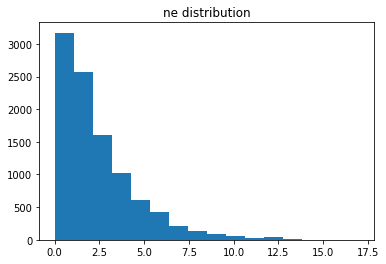

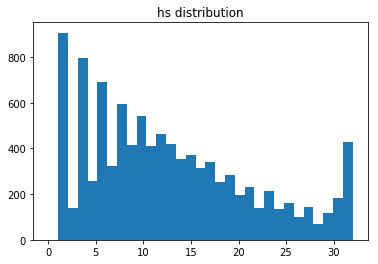

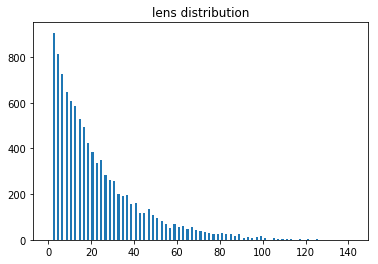

In [18]:
PROB_BRANCH = 0.7
NUM = 10000
MAX_DEPTH = 30
nes = []
hs = []
lens = []
examples = []
i = 0
while True:
    t = gen_tree()
    if isinstance(t, int):
        continue
    i+=1
    if i>NUM:
        break
    
    sd, h = to_sd(t)
    ne = num_extrem_vals(sd)
    nes.append(ne)
    hs.append(h)
    lens.append(len(sd)+1)
    nodes = ' '.join(to_nlst(t))
    sd_lst = ' '.join(list(map(str, sd)))
    ne_str = str(ne)
    examples.append((nodes, sd_lst, ne_str))
    
plt.hist(nes, bins=max(nes), range=(0, max(nes)+1))
plt.title('ne distribution')
plt.show()
plt.hist(hs, bins=max(hs), range=(0, max(hs)+1))
plt.title('hs distribution')
plt.show()
plt.hist(lens, bins=max(lens), range=(0, max(lens)+1))
plt.title('lens distribution')
plt.show()

In [19]:
ne_dist = {ne:0 for ne in range(max(nes)+1)}
for ne in nes:
    ne_dist[ne] += 1

In [20]:
ne_dist

{0: 0,
 1: 3171,
 2: 2572,
 3: 1606,
 4: 1028,
 5: 608,
 6: 425,
 7: 212,
 8: 134,
 9: 91,
 10: 63,
 11: 34,
 12: 37,
 13: 12,
 14: 4,
 15: 2,
 16: 1}

# save

In [21]:
NSAMPLES = len(examples)
random.shuffle(examples)
ntrain = int(0.8 * NSAMPLES)
nvalid = int(0.1 * NSAMPLES)
ntest = int(0.1 * NSAMPLES)
train = examples[:ntrain]
valid = examples[ntrain: ntrain+nvalid]
test = examples[ntrain+nvalid:]
for dataset, dataset_type in zip([train, valid, test], ['train', 'valid', 'test']):
    with open('%s_d%d.ne.small.tsv' % (dataset_type, MAX_DEPTH), 'w') as f:
        for line in dataset:
            f.write('\t'.join(line))
            f.write('\n')